In [1]:
import numpy as np
import matplotlib.pyplot as plt
from KMCLib import *
import time
#from KMCAnalysis_single_trajectory import *



# -----------------------------------------------------------------------------
# KMCLib version 2.0-a1
# Distributed under the GPLv3 license
# Copyright (C)  2012-2016  Mikael Leetmaa
# Developed by Mikael Leetmaa <leetmaa@kth.se>
#
# This program is distributed in the hope that it will be useful
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# LICENSE and README files, and the source code, for details.
#
# You should have received a copy of the GNU General Public License version 3
# (GPLv3) along with this program. If not, see <http://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------



# Introduction
We simulate a 1D system of particles. There are three types of particles : {A,B,C}, plus S the solvent. Each of them can diffuse (right or left), and can also react alone according to : 
$$
\begin{aligned}
&A \leftrightarrow B \\
&B\leftrightarrow C \\
&A \leftrightarrow C
\end{aligned}
$$
according to the reaction constant : $k_{ab}$,$k_{ba}$,$k_{ac}$,$k_{ca}$,$k_{bc}$,$k_{cb}$

The particles also interact with an external potential set by :
$$
\begin{aligned}
&V_A(x) = V_A^0/2(1 + \tanh(S_A x)) \\
&V_B(x) = V_B^0/2(1 + \tanh(S_B x)) \\
&V_C(x) = V_C^0/2(1 + \tanh(S_C x))
\end{aligned}
$$

We write the transition rates :

![alt text](transition_rate.png "Transition states")

$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{V_{AB}-V_A} \hspace{1cm} k_{bc} = k_{bc}^0e^{V_{BC}-V_B} \hspace{1cm} k_{ac} = k_{ac}^0 e^{V_{AC}-V_A}\\
&k_{ba} = k_{ab}^0 e^{V_{AB}-V_B} \hspace{1cm} k_{cb} = k_{bc}^0e^{V_{BC}-V_C} \hspace{1cm} k_{ca} = k_{ac}^0 e^{V_{AC}+V_C}
\end{cases}
$$

We write $\forall I,J \hspace{0.5cm} V_{IJ} = V_I+V_J$

Which means that the transition rates simplifies to:

$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{V_{B}} \hspace{1cm} k_{bc} = k_{bc}^0e^{V_{C}} \hspace{1cm} k_{ac} = k_{ac}^0 e^{V_{C}}\\
&k_{ba} = k_{ab}^0 e^{V_{A}} \hspace{1cm} k_{cb} = k_{bc}^0e^{V_{B}} \hspace{1cm} k_{ca} = k_{ac}^0 e^{V_{A}}
\end{cases}
$$


In [2]:
# parameters :
size = 10
rho0 = 0.1 # density of the overall number of particles

In [3]:
# Define a squared unit cell of size 1x1x1.
cell_vectors = [[   1.000000e+00,   0.000000e+00,   0.000000e+00],
                [   0.000000e+00,   1.000000e+00,   0.000000e+00],
                [   0.000000e+00,   0.000000e+00,   1.000000e+00]]
# Define a unique point within the unit cell
basis_points = [[   0.500000e+00,   0.500000e+00,   0.500000e+00]]
unit_cell = KMCUnitCell(cell_vectors=cell_vectors,
                        basis_points=basis_points)
                        # Define a 1D lattice of size size
lattice = KMCLattice(unit_cell=unit_cell,
                     repetitions=(size,1,1),
                     periodic=(False, False, False))

In [4]:
def get_space_point(lattice):
    """
    return the real space position of the basis points.
    This function use the unit cell and the repetition
    informations to generate a set of basis points throughout space.
    """
    res = list()
    for b in lattice.basis():
        #res.append([b[0],b[1],b[2]])
        #for d in range(3):
        for l3 in range(0,lattice.repetitions()[2]):
            for l2 in range(0,lattice.repetitions()[1]):
                for l1 in range(0,lattice.repetitions()[0]):
                    line = list()
                        #line.append([b+l1*lattice.unitCell().cellVectors()[0]+l2*lattice.unitCell().cellVectors()[1]+l3*lattice.unitCell().cellVectors()[2]])
                    for db in range(3):
                        line.append(b[db]+l1*lattice.unitCell().cellVectors()[0][db]+l2*lattice.unitCell().cellVectors()[1][db]+l3*lattice.unitCell().cellVectors()[2][db])
                    res.append(line)
    return np.array(res)

def Index_from_X(x,lattice):
        """
        x is a 3D vector point
        This function works together with get_space_point. given a x,
        it returns the corresponding index of get_space_point.
        !!!! Only works for 1 basis point, and squared lattice!!!!
        """
        x = x- lattice.basis()[0] # remove the coordinate of the first lattice basis point
        Ix = x[0]/lattice.unitCell().cellVectors()[0][0]
        Iy = x[1]/lattice.unitCell().cellVectors()[1][1]
        Iz = x[2]/lattice.unitCell().cellVectors()[2][2]
        return int(Ix + Iy*lattice.repetitions()[0]+ Iz*lattice.repetitions()[0]*lattice.repetitions()[1])

In [5]:
[Index_from_X(x,lattice) for x in get_space_point(lattice)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
# Generate the initial configuration array
types = ['S']*(size)# solvent everywhere
"""
Nparticles=0
k=0
while Nparticles<1 or k>10**3:
    Nparticles = np.random.poisson(rho0*size)# total number of particles in the system
    k+=1
for i in np.random.randint(0,size,size = Nparticles):
    types[i] = 'A'  # we start with only A particles
"""
types[size//2] = 'A'
#types[1] = 'B'
#types[2] = 'C'
Nparticle = 1
config = KMCConfiguration(lattice=lattice,
                          types=types,
                          possible_types=['S','A','B','C'])
#print(config._script())

In [7]:
VA0,VB0,VC0 = 1.,1.,1.
steepA,steepB,steepC = .5,.5,.5
Eab,Ebc,Eac = 0.,0.,0.

def VA(X):
   # if X[0]<=(size)//2-0.5:
   #     return 1.
   # else :
   #     return 0.
    try:
        if X.shape[0]==3:
            return VA0/2*(1+np.tanh((X[0]-size/2)*steepA))
        else:
            raise ValueError
    except:
        return VA0/2*(1+np.tanh((X-size/2)*steepA))
def VB(X):
    return VB0/2*(1+np.tanh((X[0]-size/2)*steepB))
def VC(X):
    return VC0/2*(1+np.tanh((X[0]-size/2)*steepC))
def VAB(X):
    return Eab+max(VA(X),VB(X))
def VAC(X):
    return Eac+max(VC(X),VA(X))
def VBC(X):
    return Ebc+max(VB(X),VC(X))
Vs = {'A':VA,'B':VB,'C':VC,'S':lambda X:0.,
    'AB':VAB,'BA':VAB,'AC':VAC,'CA':VAC,'BC':VBC,'CB':VBC}

from KMCLib.PluginInterfaces.KMCRateCalculatorPlugin import KMCRateCalculatorPlugin



class CustomPlugin(KMCRateCalculatorPlugin):
    def rate(self,coords,types_before,types_after,rate_constant,process_number,global_coordinate):
        #print('moved_ID = '+str(moved_ID))
        if types_before.__len__()==1:
            #return rate_constant*np.exp(-Vs[types_after[0]](global_coordinate+coords[0])+Vs[types_before[0]](global_coordinate+coords[0]))
            return rate_constant* np.exp(-(Vs[types_after[0]+types_before[0]](global_coordinate+coords[0])-Vs[types_before[0]](global_coordinate+coords[0])))
            """if types_after[0] =='A':
                return rate_constant*np.exp(VA(global_coordinate))
            elif types_after[0]=='B':
                return rate_constant*np.exp(VB(global_coordinate))
            elif types_after[0]=='C':
                return rate_constant*np.exp(VC(global_coordinate))"""
        else:
            E_before = sum([Vs[types_before[i]](global_coordinate+coords[i]) for i in range(types_before.__len__())])
            E_after = sum([Vs[types_after[i]](global_coordinate+coords[i]) for i in range(types_before.__len__())])
            """
            print('-------------------------------------------------------------------------')
            print('coordinates of the move')
            print([global_coordinate[0]+coords[i][0] for i in range(types_before.__len__())])
            print('type before the move')
            print(types_before)
            print('type after the move')
            print(types_after)
            print('energy initially')
            print(E_before)
            print('energy after')
            print(E_after)
            print('rate of the move')
            print(rate_constant*np.exp(-E_after+E_before))
            print('-------------------------------------------------------------------------')
            """
            return rate_constant*np.exp((-E_after+E_before)/2)
        return 1.
    
    def cutoff(self):
        """ Determines the cutoff for this custom model """
        return 0.0

In [8]:
import Process
# just diffusive process so far
interactions  = Process.make_interactions(1.,1.,ChemicalMove=True)
#from CustomRate import *
interactions.setRateCalculator(rate_calculator=CustomPlugin)

# Generate the KMC model to run.
model = KMCLatticeModel(configuration=config,
                        interactions=interactions)
control_parameters = KMCControlParameters(number_of_steps=10000,
                                          dump_interval=1000,
                                          analysis_interval=1,
                                          seed=None)

from KMCAnalysis_density_distribution import *
from KMCAnalysis_single_trajectory import *
from KMCAnalysis_diffusive_flux import *
MyAnalysis = [Density_thermal_av(['A','B','C'],
                    control_parameters.analysisInterval(),
                    control_parameters.numberOfSteps()),
                DiffusiveFlux(['A','B','C'],
                    control_parameters.analysisInterval(),
                    control_parameters.numberOfSteps()),
                SingleTrajectory('A',
                    control_parameters.analysisInterval(),
                    control_parameters.numberOfSteps())]#,
                #SingleTrajectory('B',
                #    control_parameters.analysisInterval(),
                #    control_parameters.numberOfSteps()),
                #SingleTrajectory('C',
                #    control_parameters.analysisInterval(),
                #    control_parameters.numberOfSteps())]

In [9]:
t0 = time.perf_counter()
model.run(control_parameters,trajectory_filename='test.py',
          trajectory_type='xyz',
          analysis = MyAnalysis)
print('execution time : '+str(time.perf_counter()-t0))

 KMCLib: setting up the backend C++ object.
 KMCLib: Runing for 10000 steps, starting from time: 0.000000

 KMCLib: 1000 steps executed. time:     2.5813085282e+02 
 KMCLib: 2000 steps executed. time:     5.2501743784e+02 
 KMCLib: 3000 steps executed. time:     7.9602143428e+02 
 KMCLib: 4000 steps executed. time:     1.0564371957e+03 
 KMCLib: 5000 steps executed. time:     1.2988919596e+03 
 KMCLib: 6000 steps executed. time:     1.5535032691e+03 
 KMCLib: 7000 steps executed. time:     1.8397071407e+03 
 KMCLib: 8000 steps executed. time:     2.1207352124e+03 
 KMCLib: 9000 steps executed. time:     2.3858693053e+03 
 KMCLib: 10000 steps executed. time:     2.6588779774e+03 
execution time : 2.6827072050000424


In [10]:
get_space_point(config.lattice())[:,0],MyAnalysis[1].results()['A']

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 array([-0.0003799 ,  0.00075979, -0.00265928,  0.00227938,  0.00075979,
        -0.00417887, -0.0003799 ,  0.00569846, -0.00531856,  0.00341908]))

/home/hcleroy/anaconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/hcleroy/anaconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


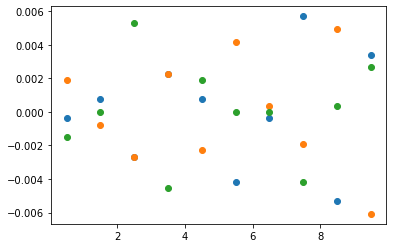

In [11]:
plt.scatter(get_space_point(config.lattice())[:,0],MyAnalysis[1].results()['A'])
plt.scatter(get_space_point(config.lattice())[:,0],MyAnalysis[1].results()['B'])
plt.scatter(get_space_point(config.lattice())[:,0],MyAnalysis[1].results()['C'])

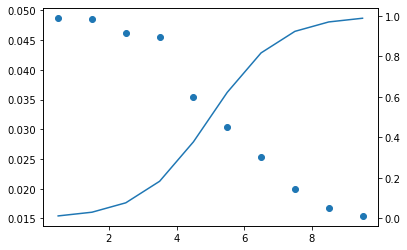

In [12]:
#########################
#########################
#Not the right normalization most likely
fig,ax = plt.subplots()
#ax.plot(get_space_point(config.lattice())[:,0],rho_stat_mech)
ax.scatter(get_space_point(config.lattice())[:,0],MyAnalysis[0].results()[0]/Nparticle)
#ax.scatter(get_space_point(config.lattice())[:,0],MyAnalysis[0].results()[1]/Nparticle)
#ax.scatter(get_space_point(config.lattice())[:,0],MyAnalysis[0].results()[2]/Nparticle)
ax2 = ax.twinx()
ax2.plot(get_space_point(config.lattice())[:,0],[VA(x) for x in get_space_point(config.lattice())])
#ax2.plot(get_space_point(config.lattice())[:,0],[VB(x) for x in get_space_point(config.lattice())])
#ax2.plot(get_space_point(config.lattice())[:,0],[VC(x) for x in get_space_point(config.lattice())])

In [13]:
print(sum(rho_stat_mech))
print(sum(MyAnalysis[0].results()[0]))

NameError: name 'rho_stat_mech' is not defined

In [ ]:
for i in range(3):
    print(np.sum(MyAnalysis[0].results()[i]))

0.2808028591557123
0.02851776077853754
0.4446016857966014


In [ ]:
for b in config.lattice().basis():
    for db in range(3):        
        print(b[db])

0.5
0.5
0.5
